In [23]:
import numpy as np
from scipy.stats import percentileofscore
import itolapi
from itolapi import Itol
import os
from pathlib import Path
import sys

import pandas as pd
import toytree       # a tree plotting library
import toyplot       # a general plotting library
import numpy as np   # numerical library
import os
from Bio import SeqIO
from Bio import Entrez
import subprocess
import toyplot.png
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import subprocess
import multiprocessing as mp
import ast
from Bio.Data import CodonTable

from Bio.Seq import Seq
from Bio.SeqUtils import seq3
import random
from Bio.SeqUtils import GC123
from collections import Counter

# Diamond blastp

In [2]:
dfc=pd.read_csv("corrected_cluster_info.tsv",sep="\t",index_col=0)

genes=set(dfc.index)
genomes=set(dfc.genome)

In [6]:
hgt_intervals=[]
meta_intervals=[]
for index, row in dfc.iterrows():
    hgt_intervals.extend(ast.literal_eval(row.HGT_intervals))
    meta_intervals.extend(ast.literal_eval(row.Meta_intervals))

In [3]:
#run diamond blastp for each interval in each genome, including building a database
for g in genomes:
    try:
        input_file = open(f"/n/holyscratch01/extavour_lab/Lab/rkapoor/ncbi_dataset/data/{g}/protein.faa")
        genome_dict = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))
        subprocess.run(["sh","make_diamond_genome_db.sh",g])
        for h in hgts_2+metas_2:
            if g in h:
                f=open(f"same_genome_prot_queries/{h}.fasta","w")
                inter=ast.literal_eval(h.split("_")[-1])
                seq=str(genome_dict[h.split(";")[1]].seq)
                seq=seq[inter[0]-1:inter[1]]
                f.write(">"+h+"\n")
                f.write(seq+"\n")
                f.close()
                subprocess.run(["sh","run_diamond_query.sh",h,g])
    except:
        print(g)

diamond v2.0.15.153 (C) Max Planck Society for the Advancement of Science
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 10
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Database input file: /n/holyscratch01/extavour_lab/Lab/rkapoor/ncbi_dataset/data/GCF_019393585.1/protein.faa
Opening the database file...  [0.001s]
Loading sequences...  [0.061s]
Masking sequences...  [0.073s]
Writing sequences...  [0.019s]
Hashing sequences...  [0.004s]
Loading sequences...  [0s]
Writing trailer...  [0s]
Closing the input file...  [0s]
Closing the database file...  [0.001s]

Database sequences  23859
  Database letters  16270257
     Database hash  dae1e3939de3324e7e949bd7fe866a52
        Total time  0.161000s
diamond v2.0.15.153 (C) Max Planck Society for the Advancement of Science
Documentation, support and updates available at http://www.diamondsea

In [40]:
#parse blast results and include information on the locus/coding gene for each protein hit
def write_same_genome(genome):
    file_path=f"/n/holyscratch01/extavour_lab/Lab/rkapoor/ncbi_dataset/data/{genome}/genomic.gff"
    column_names = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
    dfg = pd.read_csv(file_path, sep='\t', comment='#', names=column_names)
    cdfg=dfg[dfg["type"]=="CDS"]
    cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]
    for interv in [x for x in os.listdir("same_genome_prot_results") if genome in x]:
        if interv+".tsv" not in os.listdir("same_genome_prot"):
            gene=interv.split(";")[1]
            df_hgt=pd.read_csv(f"same_genome_prot_results/{interv}",sep="\t",names="qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore".split())
            dfhgti=df_hgt.copy()
            for index, row in dfhgti.iterrows():
                sprotein=row[1]
                RNA=[x.split(";Parent=rna-")[1].split(";")[0] for x in dfg.attributes if "ID=cds-"+sprotein in x][0]
                gene_name=[x.split(";Parent=gene-")[1].split(";")[0] for x in dfg.attributes if "ID=rna-"+RNA in x][0]
                dfgene=dfg[dfg.attributes.str.contains("ID=gene-"+gene_name)]
                dfhgti.loc[index,["seqid","start","end"]]=dfgene.loc[:,["seqid","start","end"]].iloc[0,:]
                dfhgti.loc[index,"gene_name"]=gene_name
            dfhgti.to_csv(f"same_genome_prot_results/{interv}",sep="\t")
    return  

In [42]:
with mp.Pool(9) as p:
    results = p.map(write_same_genome, genomes) 

/tmp/ipykernel_2895051/176159529.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]
/tmp/ipykernel_2895051/176159529.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]
/tmp/ipykernel_2895051/176159529.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



IndexError: list index out of range

In [5]:
import os

directory = "same_genome_prot_results"  # Replace with the path to your directory

for filename in os.listdir(directory):
    if filename.endswith(".csv.tsv"):
        new_filename = os.path.join(directory, filename.replace(".csv.tsv", ".tsv"))
        os.rename(os.path.join(directory, filename), new_filename)

## Analyze within-genome hits

In [7]:
hgt_evalues={}
meta_evalues={}
#for a range of e-values, make a dictionary of isolated hits in the genome
#metazoan-only hits: meta e<1e-10, no hgt <10
#hgt-only hits: hgt e<1e-10, no meta >10
#pool by locus
for evalue in [1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10]:
    hgt_onlydict={}
    for interv in [x for x in os.listdir("same_genome_prot_results") if "HGT" in x and ".tsv" in x and x.split(".tsv")[0] in hgt_intervals]:

        df_hgt=pd.read_csv(f"same_genome_prot_results/{interv}",sep="\t")
        hgts_only=set(df_hgt[df_hgt["evalue"]<evalue].gene_name)
        for meta_interv in [x for x in os.listdir("same_genome_prot_results") if interv.split(";")[1] in x and "Meta" in x and ".tsv" in x]:
            df_meta=pd.read_csv(f"same_genome_prot_results/{meta_interv}",sep="\t")
            hgts_only=hgts_only-set(df_meta.gene_name)
        hgt_onlydict[interv.replace(".tsv","")]=hgts_only
    hgt_evalues[evalue]=hgt_onlydict
    meta_onlydict={}
    for interv in [x for x in os.listdir("same_genome_prot_results") if "Meta" in x and ".tsv" in x and x.split(".tsv")[0] in meta_intervals]:

        df_meta=pd.read_csv(f"same_genome_prot_results/{interv}",sep="\t")
        metas_only=set(df_meta[df_meta["evalue"]<evalue].gene_name)
        for hgt_interv in [x for x in os.listdir("same_genome_prot_results") if interv.split(";")[1] in x and "HGT" in x and ".tsv" in x]:
            df_hgt=pd.read_csv(f"same_genome_prot_results/{hgt_interv}",sep="\t")
            metas_only=metas_only-set(df_hgt.gene_name)
        meta_onlydict[interv.replace(".tsv","")]=metas_only
    meta_evalues[evalue]=meta_onlydict
    
    

In [ ]:
from collections import Counter

In [8]:
evals=[]
n_meta_only=[]
for e in meta_evalues:
    evals.append(e)
    n_meta_only.append(len([x for x in meta_evalues[e] if len(meta_evalues[e][x])>0]))
    

In [9]:
evals=[]
n_hgt_only=[]
for e in hgt_evalues:
    evals.append(e)
    n_hgt_only.append(len([x for x in hgt_evalues[e] if len(hgt_evalues[e][x])>0]))

In [10]:
genes=list(dfc.representative_seq)

In [11]:
##paralogs=hits for all meta and hgt intervals
evalue_paralogs={}
for evalue in [1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10]:
    paralogs={}
    for gene in genes:
        interg=[x for x in os.listdir("same_genome_prot_results") if gene in x and ".tsv" in x]
        loc_sets=[]
        for interi in interg:
            dfg=pd.read_csv(f"same_genome_prot_results/{interi}",sep="\t")
            dfg=dfg[dfg.evalue<evalue]
            loc_sets.append(set(dfg.gene_name))
        paralogs[gene]=set.intersection(*loc_sets)
    evalue_paralogs[evalue]=paralogs
    

In [ ]:
evals=[]
paralogs=[]
for e in evalue_paralogs:
    evals.append(e)
    paralogs.append(len([x for x in evalue_paralogs[e] if len(evalue_paralogs[e][x])>1]))

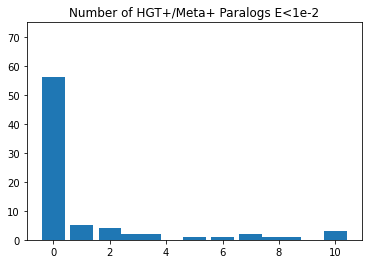

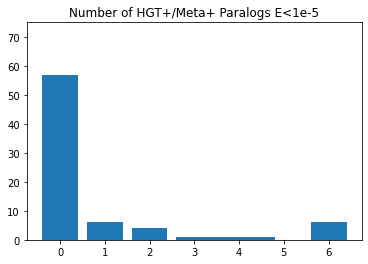

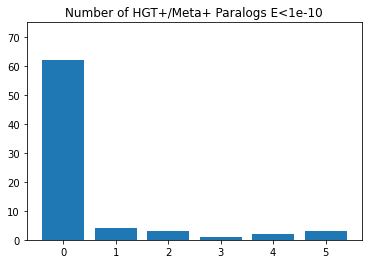

In [41]:
# Your data

plt.title("Number of HGT+/Meta+ Paralogs E<1e-2")
data = [len(evalue_paralogs[1e-2][x]) - 1 for x in evalue_paralogs[1e-2]]
# Calculate unique counts
unique_counts = sorted(set(data))
# Create a histogram with one bin per unique count
plt.hist(data, bins=unique_counts, rwidth=0.8, align='left')
plt.ylim(0,len(genes))
plt.show()

plt.title("Number of HGT+/Meta+ Paralogs E<1e-5")
data = [len(evalue_paralogs[1e-5][x]) - 1 for x in evalue_paralogs[1e-5]]
# Calculate unique counts
unique_counts = sorted(set(data))
# Create a histogram with one bin per unique count
plt.hist(data, bins=unique_counts, rwidth=0.8, align='left')
plt.ylim(0,len(genes))
plt.show()

plt.title("Number of HGT+/Meta+ Paralogs E<1e-10")
data = [len(evalue_paralogs[1e-10][x]) - 1 for x in evalue_paralogs[1e-10]]
# Calculate unique counts
unique_counts = sorted(set(data))
# Create a histogram with one bin per unique count
plt.hist(data, bins=unique_counts, rwidth=0.8, align='left')
plt.ylim(0,len(genes))
plt.show()

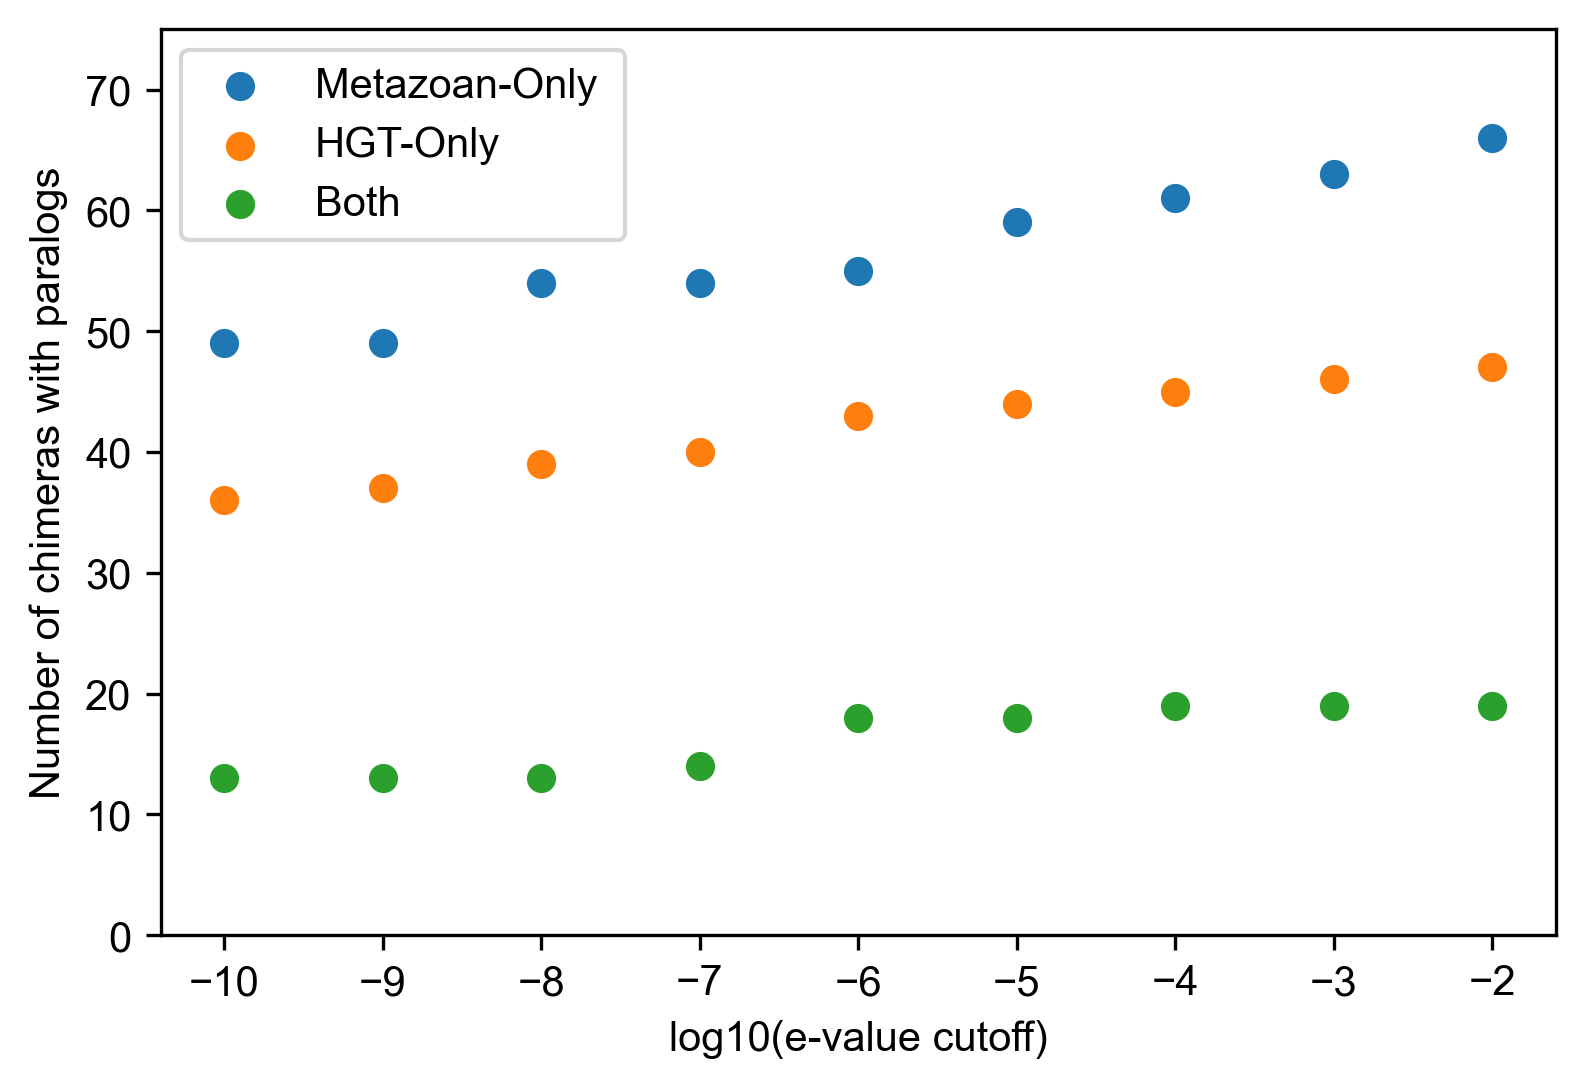

In [113]:

plt.scatter(np.log10(evals),n_meta_only,label="Metazoan-Only ")
plt.scatter(np.log10(evals),n_hgt_only,label="HGT-Only")
plt.scatter(np.log10(evals),paralogs,label="Both")
plt.ylim(0,len(genes))
plt.xlabel("log10(e-value cutoff)")
plt.ylabel("Number of chimeras with paralogs")
plt.legend()
plt.show()

## Venn diagram generation
Numbers indicate number of hgt-chimeras with at least one hit w/in the genome

In [14]:
genus_species=list(dfc[dfc.tax_span_rank.isin(["species","genus","subgenus","subspecies"])].representative_seq)
not_genus_species=list(dfc[~dfc.tax_span_rank.isin(["species","genus","subgenus","subspecies"])].representative_seq)

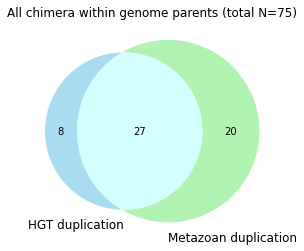

In [12]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Set data for the two sets
e=1e-10
# Create the figure and axes
# First Venn diagram
hgt_only = set([x.split(";")[1] for x in hgt_evalues[e] if len(hgt_evalues[e][x]) > 0 ])
meta_only = set([x.split(";")[1] for x in meta_evalues[e] if len(meta_evalues[e][x]) > 0 ])
venn2([hgt_only, meta_only], set_labels=('HGT duplication', 'Metazoan duplication'), set_colors=('skyblue', 'lightgreen'), alpha=0.7)

plt.title("All chimera within genome parents (total N=75)")

# Show the plot
plt.savefig('hgt_venn_all.svg',format='svg')
plt.show()

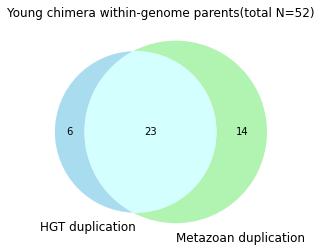

In [15]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Set data for the two sets
e=1e-10
# Create the figure and axes
# First Venn diagram
hgt_only = set([x.split(";")[1] for x in hgt_evalues[e] if len(hgt_evalues[e][x]) > 0 and x.split(";")[1] in genus_species])
meta_only = set([x.split(";")[1] for x in meta_evalues[e] if len(meta_evalues[e][x]) > 0 and x.split(";")[1] in genus_species])
venn2([hgt_only, meta_only], set_labels=('HGT duplication', 'Metazoan duplication'), set_colors=('skyblue', 'lightgreen'), alpha=0.7)

plt.title("Young chimera within-genome parents(total N=52)")

# Show the plot
plt.savefig('hgt_venn_young.svg',format='svg')
plt.show()

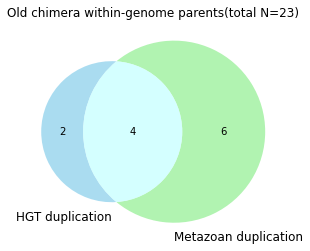

In [112]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Set data for the two sets
e=1e-10
# Create the figure and axes
# First Venn diagram
hgt_only = set([x.split(";")[1] for x in hgt_evalues[e] if len(hgt_evalues[e][x]) > 0 and x.split(";")[1] in not_genus_species])
meta_only = set([x.split(";")[1] for x in meta_evalues[e] if len(meta_evalues[e][x]) > 0 and x.split(";")[1] in not_genus_species])
venn2([hgt_only, meta_only], set_labels=('HGT duplication', 'Metazoan duplication'), set_colors=('skyblue', 'lightgreen'), alpha=0.7)

plt.title("Old chimera within-genome parents(total N=23)")

# Show the plot
plt.savefig('hgt_venn_old.svg',format='svg')
plt.show()

## Tandem duplication analysis 
Infers hgt-chimeras that might have originated via tandem duplication due to proximity (in number of intervening genes or nucleotides) to isolate parents

In [11]:
def calculate_inbetween_genes(interval1,interval2,self_loc,gene_name1,gene_name2):
    #given two tuple coordinates of two loci on the scaffold/loc with accession "self_loc", returns the number of intervening genes
    start1,end1=interval1
    start2,end2=interval2
    dfi=dfgenes[dfgenes.seqid==self_loc]
    dfi=dfi[dfi.start>=min(end1,end2)]
    dfi=dfi[dfi.end<=max(start1,start2)]
    dfi=dfi[~dfi.attributes.str.contains(gene_name1+";")]
    dfi=dfi[~dfi.attributes.str.contains(gene_name2+";")]
    return dfi.shape[0]
def calculate_min_distance(interval1, interval2):
    # given loci intervals provided as tuples (start, end), returns the distance between the two loci
    start1, end1 = interval1
    start2, end2 = interval2
    
    # Calculate the cases
    if end1 < start2:
        return start2 - end1
    elif end2 < start1:
        return start1 - end2
    else:
        return 0

In [201]:
!rm -r "prot_same_genome_distance"
!mkdir "prot_same_genome_distance"

In [118]:
#create dataframes with the distance between each chimera and all blast hits
for genome in genomes:
    file_path=f"ncbi_dataset/data/{genome}/genomic.gff"
    column_names = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
    dfg = pd.read_csv(file_path, sep='\t', comment='#', names=column_names)
    cdfg=dfg[dfg.type=="CDS"]
    cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]
    dfgenes=dfg[dfg.type=="gene"]
    genome_inters=[x for x in intervals if genome in x]
    for genome_inter in genome_inters:
        
        #obtain the protein-coding gene name and coordinates 
        inter_pro=genome_inter.split(';')[1]
        RNA=[x.split(";Parent=rna-")[1].split(";")[0] for x in dfg.attributes if "ID=cds-"+inter_pro in x][0]
        #gene name
        inter_gene_name=[x.split(";Parent=gene-")[1].split(";")[0] for x in dfg.attributes if "ID=rna-"+RNA in x][0]
        #scaffold name of the protein
        inter_gene_seqid=list(dfg[dfg.attributes.str.contains("ID=gene-"+inter_gene_name)].seqid)[0]
        
        #start,end coordinate of the gene
        inter_gene_start=list(dfg[dfg.attributes.str.contains("ID=gene-"+inter_gene_name)].start)[0]
        inter_gene_end=list(dfg[dfg.attributes.str.contains("ID=gene-"+inter_gene_name)].end)[0]

        df_hgt=pd.read_csv(f"same_genome_prot_results/{genome_inter}.tsv",sep="\t")
        df_hgt=df_hgt[df_hgt.gene_name!=inter_gene_name]
        
        #remove genes overlapping with chimeric locus from the intervening gene distance calculation 
        df_hgt["same_chromosome"]=[x==inter_gene_seqid for x in df_hgt.seqid]
        df_hgt["overlap_with_interval"] = df_hgt.apply(lambda row: max(0, min(row["end"], inter_gene_end) - max(row["start"], inter_gene_start)), axis=1)
        df_hgt=df_hgt[df_hgt["overlap_with_interval"]<15]
        
        for index, row in df_hgt.iterrows():
            if row["same_chromosome"]:
                df_hgt.loc[index,"distance"]=calculate_min_distance((inter_gene_start,inter_gene_end), (row.start,row.end))
                df_hgt.loc[index,"gene_distance"]=calculate_inbetween_genes((inter_gene_start,inter_gene_end), (row.start,row.end),inter_gene_seqid, inter_gene_name,row.gene_name)
        df_hgt.loc[df_hgt.groupby("gene_name")["evalue"].idxmin()].to_csv(f"prot_same_genome_distance/{genome_inter}")



NameError: name 'genome_uniques' is not defined

In [17]:
 #creates a dataframe with hit data for all intervals at e=1e-10
f=open("gene_names.txt","r").readlines()
gene_map={x.split("--")[0]:x.split("--")[1].strip() for x in f}
inter_df=pd.DataFrame(index=[x for x in os.listdir("prot_same_genome_distance") if ";" in x and ((x in meta_intervals) or (x in hgt_intervals))])
for x in set([x for x in os.listdir("prot_same_genome_distance") if ";" in x and ((x in meta_intervals) or (x in hgt_intervals))]):

    df=pd.read_csv(f"prot_same_genome_distance/{x}")
    if "Meta" in x:
        df=df[df.gene_name.isin(meta_evalues[1e-10][x])]
    else:
        df=df[df.gene_name.isin(hgt_evalues[1e-10][x])]
    if df.shape[0]>0:
        inter_df.loc[x,"prot"]=x.split(";")[1]
        inter_df.loc[x,"gene_loc"]=gene_map[x.split(";")[1]]
        inter_df.loc[x,"annot"]=x.split(";")[-1].split("_")[0]
        inter_df.loc[x,"prot_name"]=str([(x,y) for x,y in zip(df["sseqid"],df["gene_name"])])
        inter_df.loc[x,"min_eval"]=min(df["evalue"])
        inter_df.loc[x,"n_hits"]=df.shape[0]
        inter_df.loc[x,"n_same_chromosome"]=df[df.same_chromosome==True].shape[0]
        inter_df.loc[x,"min_eval"]=min(df["evalue"])
        inter_df.loc[x,"min_eval_loc"]=str(df.loc[df["evalue"].idxmin(),"gene_name"])
        inter_df.loc[x,"min_eval_gene"]=str(df.loc[df["evalue"].idxmin(),"sseqid"])
        if df[df.same_chromosome==True].shape[0]>0:
            inter_df.loc[x,"min_distance"]=min(df[df.same_chromosome==True]["distance"])
            inter_df.loc[x,"min_distance_loc"]=str(df.loc[df["distance"].idxmin(),"gene_name"])
            inter_df.loc[x,"min_distance_eval"]=str(df.loc[df["distance"].idxmin(),"evalue"])
            inter_df.loc[x,"min_gene_distance"]=min(df[df.same_chromosome==True]["gene_distance"])
            inter_df.loc[x,"min_gene_distance_loc"]=str(df.loc[df["gene_distance"].idxmin(),"gene_name"])
            inter_df.loc[x,"min_gene_distance_gene"]=str(df.loc[df["gene_distance"].idxmin(),"sseqid"])
            inter_df.loc[x,"min_gene_distance_eval"]=str(df.loc[df["gene_distance"].idxmin(),"evalue"])


In [18]:
inter_df=inter_df[inter_df.prot.astype(str)!='nan']

In [19]:
found_nuc=[]
for index,row in inter_df.iterrows():
    gen=index.split(";")[0]
    dfnuc=pd.read_csv(f"blastn_results/{gen}_results.txt",sep="\t",header=None)
    nuc_hits=set(["_".join(x.split("cds_")[1].split("_")[0:2]) for x in dfnuc[dfnuc[0]==index][1]])
    if len(set([x[1] for x in ast.literal_eval(str(row.prot_name)) if x[0] in nuc_hits]))>0:
        found_nuc.append(index)
        inter_df.loc[index,"nuc_hits"]=str(set([x[1] for x in ast.literal_eval(row.prot_name)]))
    

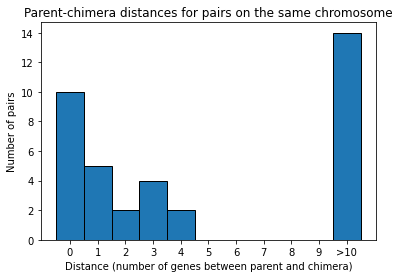

In [24]:
modified_data = []
for distance in samec.min_gene_distance:
    if distance < 10:
        modified_data.append(distance)
    else:
        modified_data.append(10)  # Group values greater than 10 together as 11

# Create a histogram with specified bins
m=dict(Counter(modified_data))
plt.bar([x for x in m], [m[x] for x in m], edgecolor='black',width=1)

# # Customize x-axis labels
x_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '>10']
plt.xticks(np.arange(len(bins)), x_labels)

y_labels =list(range(0,16,2))
plt.yticks(y_labels)
plt.xlabel('Distance (number of genes between parent and chimera)')
plt.ylabel('Number of pairs')
plt.title('Parent-chimera distances for pairs on the same chromosome')
plt.savefig('Parent-chimera_distances.svg',format='svg')

In [113]:
less_than2=samec[samec.min_gene_distance<=2]


In [48]:
for x in set(less_than2.prot):
    if len(set(less_than2[less_than2.prot==x].annot))==2:
        print(x)

XP_025018608.1


In [19]:
less_than2[less_than2.min_eval_loc==less_than2.min_gene_distance_loc].shape

(13, 14)

## Retrotransposition
Determine retrotransposition candidates: 1. intervals not found on the same chromosome/scaffold as their parents; 2.spanned by 0 introns in the chimera and >=1 intron in the chimera

In [31]:
def get_exon_boundaries(n):
    #return a list of touples containing demarcating the protein into exons 
    genome=n.split(";")[0]
    file_path=f"ncbi_dataset/data/{genome}/genomic.gff"
    column_names = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
    dfg = pd.read_csv(file_path, sep='\t', comment='#', names=column_names)
    gene=n.split(";")[1]
    rna=[x.split("Parent=rna-")[1].split(";")[0] for x in dfg[dfg.attributes.str.contains(f"protein_id={gene}")].attributes]
    rna=rna[0]
    gene_df=dfg[dfg.attributes.str.contains(rna)]
 
    cdsg=gene_df[gene_df.type=="CDS"]
    cdsg=cdsg.sort_values("start")
    aas=[0]
    for index, row in cdsg.iterrows():
        aas.append((row.end-row.start+1)/3+aas[-1])
    aas[-1]=aas[-1]-1
    return aas

In [27]:
def calculate_overlap_percentage(intervals, q):
    #for a list of interval touples (intervals), calculate the length overlap of each with the interval q
    def get_overlap_percentage(interval1, interval2):
        # Calculate the intersection (overlap) between two intervals
        intersection_start = max(interval1[0], interval2[0])
        intersection_end = min(interval1[1], interval2[1])

        # Calculate the length of the intersection
        intersection_length = max(0, intersection_end - intersection_start)

        # Calculate the length of the query interval
        q_length = q[1] - q[0]

        # Calculate the percentage of overlap between the intervals
        overlap_percentage = (intersection_length / q_length) * 100

        return overlap_percentage

    overlap_percentages = {}
    for interval in intervals:
        overlap_percentage = get_overlap_percentage(interval, q)
        overlap_percentages[interval]=(overlap_percentage)

    return overlap_percentages


In [65]:
set([";".join(x.split(";")[0:2]) for x in all_intervals])

['GCF_021130785.1;XP_046664087.1',
 'GCF_001901225.1;XP_027204138.1',
 'GCF_000591075.1;XP_023346081.1',
 'GCF_004193835.1;XP_028168683.1',
 'GCF_004354385.1;XP_034487048.1',
 'GCF_921293095.1;XP_046403459.1',
 'GCF_021134715.1;XP_046456339.1',
 'GCF_025091365.1;XP_050528041.1',
 'GCF_023864275.1;XP_049785902.1',
 'GCF_000002335.3;XP_015833841.1',
 'GCF_003710045.2;XP_031842795.1',
 'GCF_010883055.1;XP_033212818.1',
 'GCF_000612105.2;XP_012275032.1',
 'GCF_014529535.1;XP_037049533.1',
 'GCF_014529535.1;XP_037041958.1',
 'GCF_016920785.2;XP_029821973.3',
 'GCF_023897955.1;XP_049849891.1',
 'GCF_000239435.1;XP_015786976.1',
 'GCF_000475195.1;XP_026676798.1',
 'GCF_020424385.1;XP_045595407.1',
 'GCF_002217175.1;XP_035711638.1',
 'GCF_002217175.1;XP_021960153.2',
 'GCF_002217175.1;XP_035708240.1',
 'GCF_021234035.1;XP_046646423.1',
 'GCF_905333055.1;XP_045779580.1',
 'GCF_000002335.3;XP_015834127.1',
 'GCF_018991925.1;XP_042220148.1',
 'GCF_021134715.1;XP_046453153.1',
 'GCF_917208135.1;XP

In [71]:
inter_overlaps={}
all_intervals=hgt_intervals+meta_intervals
genome_gene=set([";".join(x.split(";")[0:2]) for x in all_intervals])
for g in genome_gene:
    c={}
    b=get_exon_boundaries(g)
    inters=[(b[i],b[i+1]) for i in range(len(b)-1)]
    td=[x for x in all_intervals if g in x]
    for gi in td:
        inter_overlaps[gi]=calculate_overlap_percentage(inters, ast.literal_eval(gi.split("_")[-1]))
  

In [78]:
for index,row in inter_df.iterrows():
    inter_df.loc[index,"n_exons"]=n_exons[index]

In [82]:
for n,row in inter_df.iterrows():
   
    df=pd.read_csv(f"same_genome_prot_results/{n}.tsv",sep="\t")
    putative_par=df[df.gene_name!=list(df[df.sseqid==n.split(";")[1]].gene_name)[0]].sort_values("evalue").iloc[0,:]
    par=putative_par["sseqid"]
    parstart=putative_par["sstart"]
    parend=putative_par["send"]

    b=get_exon_boundaries(n.split(";")[0]+";"+par)
    inters=[(b[i],b[i+1]) for i in range(len(b)-1)]
    q=(parstart,parend)

    overlaps=calculate_overlap_percentage(inters,q)
    n_exons=len([x for x in overlaps if overlaps[x]>0])
    if n_exons>1:
        inter_df.loc[n,"retro"]=True
        inter_df.loc[n,"parent_n_exons"]=n_exons

In [90]:
inter_df[(inter_df.n_exons==1)&(inter_df.parent_n_exons>0)].shape[0]

11

In [33]:
nuc=inter_df[inter_df.nuc_hits.astype(str)!="nan"]
to_investigate=set(single_exon_span)&set(nuc[nuc.min_distance.astype(str)=="nan"].index)
for n in to_investigate:
   
    df=pd.read_csv(f"same_genome_prot_results/{n}.tsv",sep="\t")
    putative_par=df[df.gene_name!=list(df[df.sseqid==n.split(";")[1]].gene_name)[0]].sort_values("evalue").iloc[0,:]
    par=putative_par["sseqid"]
    parstart=putative_par["sstart"]
    parend=putative_par["send"]

    b=get_exon_boundaries(n.split(";")[0]+";"+par)
    inters=[(b[i],b[i+1]) for i in range(len(b)-1)]
    q=(parstart,parend)

    overlaps=calculate_overlap_percentage(inters,q)
    n_exons=len([x for x in overlaps if overlaps[x]>0])
    if n_exons>1:
        print(n,par,parstart,parend,n_exons)

GCF_003710045.2;XP_031842795.1;Meta_(202,263) XP_031849923.1 512 577 2


# Identify HGT-less isoforms
Inspect blastp hits to determine if any isoforms of hgt-chimeric genes lack the hgt interval

In [73]:
input_file = open("inter_pro/hgt.fasta")
hgt_dict = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))
hgt_inters=hgt_dict.keys()

In [128]:
missing_hgt_isoforms={}
for genome in set(dfc.genome):
    file_path=f"ncbi_dataset/data/{genome}/genomic.gff"
    column_names = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
    dfg = pd.read_csv(file_path, sep='\t', comment='#', names=column_names)
    cdfg=dfg[dfg.type=="CDS"]
    cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]
    dfgenes=dfg[dfg.type=="gene"]
    genome_inters=[x for x in hgt_inters if genome in x]
    for genome_inter in genome_inters:
        inter_pro=genome_inter.split(';')[1]
        print(inter_pro)
        RNA=[x.split(";Parent=rna-")[1].split(";")[0] for x in dfg.attributes if "ID=cds-"+inter_pro in x][0]
        inter_gene_name=[x.split(";Parent=gene-")[1].split(";")[0] for x in dfg.attributes if "ID=rna-"+RNA in x][0]
        df_hgt=pd.read_csv(f"same_genome_prot_results/{genome_inter}.tsv",sep="\t")
        df_hgt=df_hgt[df_hgt.gene_name==inter_gene_name]
        missing_hgt_isoforms[genome_inter]=set(cdfg[cdfg.attributes.str.contains(inter_gene_name)].CDS)-set(df_hgt.sseqid)
        

/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_045779580.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_023346081.1
XP_023329593.1
XP_023332299.1
XP_023328891.1
XP_023324156.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_029662819.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_034487048.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_014216391.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_048512468.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_044763649.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_023236565.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_031340986.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_037943392.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_049849891.1
XP_049849988.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_033212818.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_046664087.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_046646423.1
XP_046649021.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_022178340.1
XP_022173178.1
XP_022173178.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_015833841.1
XP_015834127.1
XP_015837071.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_037049533.1
XP_037041958.1
XP_037030969.1
XP_037026007.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_046403459.1
XP_046402901.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_034827763.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_026676798.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_050528041.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_029821973.3
XP_040073766.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_037790819.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_018903502.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_015786976.1
XP_025018608.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_051173821.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_049881687.1
XP_049881676.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_042908388.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_027204138.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_044731417.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_041972388.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_036141434.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_021699539.1
XP_021699539.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_031842795.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_012275032.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_044009448.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_035711638.1
XP_021960153.2
XP_035708240.1
XP_035716531.1
XP_035715441.1
XP_035708168.1
XP_035715507.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_026318555.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_023318028.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_046594669.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_049511280.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_028168683.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_042220148.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_034233350.1
XP_034245505.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_049785902.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_046456339.1
XP_046453153.1
XP_046439036.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_040568466.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_045595407.1
XP_045614234.1


/tmp/ipykernel_1407426/350682668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


XP_036230923.1


In [131]:
missing_hgt_isoforms

{'GCF_905333055.1;XP_045779580.1;HGT_(1,110)': set(),
 'GCF_000591075.1;XP_023346081.1;HGT_(205,261)': set(),
 'GCF_000591075.1;XP_023329593.1;HGT_(204,256)': set(),
 'GCF_000591075.1;XP_023332299.1;HGT_(346,400)': set(),
 'GCF_000591075.1;XP_023328891.1;HGT_(339,391)': set(),
 'GCF_000591075.1;XP_023324156.1;HGT_(373,795)': set(),
 'GCF_003651465.1;XP_029662819.1;HGT_(20,127)': set(),
 'GCF_004354385.1;XP_034487048.1;HGT_(412,553)': set(),
 'GCF_000648655.2;XP_014216391.1;HGT_(58,275)': {'XP_014216392.1',
  'XP_014216393.1'},
 'GCF_917208135.1;XP_048512468.1;HGT_(33,195)': {'XP_048512469.1'},
 'GCF_907165205.1;XP_044763649.1;HGT_(158,738)': set(),
 'GCF_000671375.1;XP_023236565.1;HGT_(4,79)': set(),
 'GCF_008802855.1;XP_031340986.1;HGT_(258,806)': set(),
 'GCF_002237135.1;XP_037943392.1;HGT_(1033,1184)': set(),
 'GCF_023897955.1;XP_049849891.1;HGT_(10,328)': set(),
 'GCF_023897955.1;XP_049849988.1;HGT_(9,320)': set(),
 'GCF_010883055.1;XP_033212818.1;HGT_(21,101)': {'XP_033212820.1'},

In [138]:
len(set([x.split(";")[1] for x in missing_hgt_isoforms if len(missing_hgt_isoforms[x])>0]))

12

In [136]:
set([x.split(";")[1] for x in missing_hgt_isoforms if len(missing_hgt_isoforms[x])>0])-set(inter_df[inter_df.index.str.contains("Meta")].prot)

{'XP_014216391.1', 'XP_036141434.1', 'XP_046594669.1'}

In [87]:
dfc.loc[set([x.split(";")[1] for x in missing_hgt_isoforms if len(missing_hgt_isoforms[x])>0]),:]

/tmp/ipykernel_1529500/3941889859.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dfc.loc[set([x.split(";")[1] for x in missing_hgt_isoforms if len(missing_hgt_isoforms[x])>0]),:]


,genome,organism,description,species_set,n_species,weak_cc,tax_span,tax_span_rank,taxid_set,phylum_dist,order_dist,class_dist,secondary_chimeras
XP_018326454.1,GCF_000699045.2,Agrilus planipennis (emerald ash borer),uncharacterized protein LOC108737823 isoform X2,"{'Bactrocera neohumeralis', 'Bombus affinis', ...",188.0,12.0,Arthropoda,phylum,"{32260.0, 30213.0, 30212.0, 1437191.0, 32264.0...",{'Arthropoda': 180},"{'Coleoptera': 22, 'Hymenoptera': 85, 'Orthopt...","{'Insecta': 164, 'Arachnida': 14, 'Collembola'...","{'KAF5299873.1', 'KAG9431601.1', 'XP_046826319..."
XP_049881687.1,GCF_024362695.1,PectiNophora gossypiella (pink bollworm),uncharacterized protein LOC126377819 isoform X16,{'Pectinophora gossypiella'},1.0,68.0,Pectinophora gossypiella,species,{13191},{'Arthropoda': 1},{'Lepidoptera': 1},{'Insecta': 1},{'XP_049881687.1'}
XP_033212818.1,GCF_010883055.1,"BeloNocnema kinseyi (wasps, ants & bees)",helicase sen1-like isoform X1,"{'Pieris brassicae', 'Drosophila obscura', 'Ca...",285.0,12.0,Arthropoda,phylum,"{30212, 30213, 32260, 1437191, 7173, 32264, 59...",{'Arthropoda': 270},"{'Hymenoptera': 96, 'Blattodea': 2, 'Orthopter...","{'Insecta': 240, 'Arachnida': 19, 'Branchiopod...","{'KAI1305860.1', 'XP_038223624.1', 'KAF5299873..."
XP_049881676.1,GCF_024362695.1,PectiNophora gossypiella (pink bollworm),uncharacterized protein LOC126377819 isoform X6,"{'Pectinophora gossypiella', 'Plutella xyloste...",2.0,74.0,Heteroneura,parvorder,"{13191, 51655}",{'Arthropoda': 2},{'Lepidoptera': 2},{'Insecta': 2},"{'XP_048486914.1', 'XP_049881676.1'}"
XP_036141434.1,GCF_013373865.1,MoNomorium pharaonis (pharaoh ant),uncharacterized protein LOC105833640 isoform X3,{'Monomorium pharaonis'},1.0,73.0,Monomorium pharaonis,species,{307658},{'Arthropoda': 1},{'Hymenoptera': 1},{'Insecta': 1},{'XP_036141434.1'}
XP_052563446.1,GCF_016801865.2,Culex pipiens pallens (Northern house mosquito),uncharacterized protein LOC120430246 isoform X1,"{'Anopheles marshallii', 'Culex quinquefasciat...",18.0,31.0,Culicidae,family,"{42434, 7173, 1518534, 186751, 7176, 180454, 1...",{'Arthropoda': 18},{'Diptera': 18},{'Insecta': 18},"{'XP_040226272.2', 'XP_053660283.1', 'XP_03589..."
XP_025018608.1,GCF_000239435.1,Tetranychus urticae (two-spotted spider mite),solute carrier family 35 member B1-like isofor...,{'Tetranychus urticae'},1.0,76.0,Tetranychus urticae,species,{32264},{'Arthropoda': 1},{'Trombidiformes': 1},{'Arachnida': 1},{'XP_025018608.1'}
XP_015833841.1,GCF_000002335.3,Tribolium castaneum (red flour beetle),activating transcription factor 7-interacting ...,"{'Tribolium castaneum', 'Tribolium madens'}",2.0,10.0,Tribolium,genus,"{7070, 41895}",{'Arthropoda': 2},{'Coleoptera': 2},{'Insecta': 2},"{'XP_044271964.1', 'XP_015833841.1'}"
XP_029821973.3,GCF_016920785.2,Ixodes scapularis (black-legged tick),uncharacterized protein LOC115308258 isoform X1,"{'Ixodes scapularis', 'Ixodes persulcatus'}",2.0,16.0,Ixodes,genus,"{6945, 34615}",{'Arthropoda': 2},{'Ixodida': 2},{'Arachnida': 2},"{'XP_029821973.3', 'KAG0423773.1'}"
XP_048512468.1,GCF_917208135.1,Athalia rosae (coleseed sawfly),uncharacterized protein LOC105688654 isoform X1,{'Athalia rosae'},1.0,34.0,Athalia rosae,species,{37344},{'Arthropoda': 1},{'Hymenoptera': 1},{'Insecta': 1},{'XP_048512468.1'}


In [31]:
s="GCF_907165205.1;XP_044763649.1;(158, 738)"

In [32]:
genome=s.split(";")[0]
file_path=f"/n/holyscratch01/extavour_lab/Lab/rkapoor/ncbi_dataset/data/{genome}/genomic.gff"
column_names = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
dfg = pd.read_csv(file_path, sep='\t', comment='#', names=column_names)
cdfg=dfg[dfg.type=="CDS"]
cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]
dfgenes=dfg[dfg.type=="gene"]
genome_inters=[x for x in unique_set if genome in x]

/tmp/ipykernel_3847069/167072875.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdfg["CDS"]=[x.split(';')[0].replace("ID=cds-","") for x in cdfg.attributes]


In [33]:
df_hgt=pd.read_csv(f"same_genome_prot_results/{s}.tsv",sep="\t")

FileNotFoundError: [Errno 2] No such file or directory: 'same_genome_prot_results/GCF_907165205.1;XP_044763649.1;(158, 738).tsv'

In [29]:
df_hgt

,Unnamed: 0,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,seqid,start,end,gene_name
0,0,"GCF_019393585.1;XP_051173821.1;Meta_(672,736)",XP_051173821.1,100.0,65,0,0,1,65,672,736,2.980000e-39,136.0,NW_026137994.1,283671.0,291789.0,LOC127289743
1,1,"GCF_019393585.1;XP_051173821.1;Meta_(672,736)",XP_051169899.1,40.7,54,31,1,13,65,428,481,6.180000e-06,41.6,NW_026137938.1,1970111.0,1974369.0,LOC127287151
2,2,"GCF_019393585.1;XP_051173821.1;Meta_(672,736)",XP_051174453.1,38.2,55,29,1,13,62,537,591,2.720000e-04,37.0,NW_026138000.1,1265467.0,1272405.0,LOC127290105
3,3,"GCF_019393585.1;XP_051173821.1;Meta_(672,736)",XP_051169914.1,32.6,46,31,0,13,58,436,481,3.710000e-04,36.6,NW_026137938.1,3059659.0,3063190.0,LOC127287162
